Visiblement on overfit beaucoup, on va tester des modèles avec moins de données. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import make_pipeline
from skrub import TableVectorizer

Lecture des données

In [2]:
PATH = "./dataproject2025.csv"
df = pd.read_csv(PATH).drop(columns=["Unnamed: 0"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   issue_d                  1086236 non-null  int64  
 1   loan duration            1086236 non-null  int64  
 2   annual_inc               1086236 non-null  float64
 3   avg_cur_bal              1086236 non-null  float64
 4   bc_open_to_buy           1086236 non-null  float64
 5   bc_util                  1086236 non-null  float64
 6   delinq_2yrs              1086236 non-null  float64
 7   dti                      1086236 non-null  float64
 8   emp_length               1086236 non-null  object 
 9   emp_title                1086236 non-null  object 
 10  fico_range_high          1086236 non-null  float64
 11  funded_amnt              1086236 non-null  float64
 12  grade                    1086236 non-null  object 
 13  home_ownership           1086236 non-null 

Test avec un nombre limité de features

In [3]:
from utils import ordinal_encode
from skrub import TableVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold
from sklearn.linear_model import LinearRegression

X = ordinal_encode(df.drop(columns=["Predicted probabilities", "Predictions", "target"])
        # low information, must be redundant
        .drop(columns=["emp_title"]),drop=True)

# mixed effect like
#X["issue_d_one_hot"] = X["issue_d"].astype(str)

y = df["Predicted probabilities"]




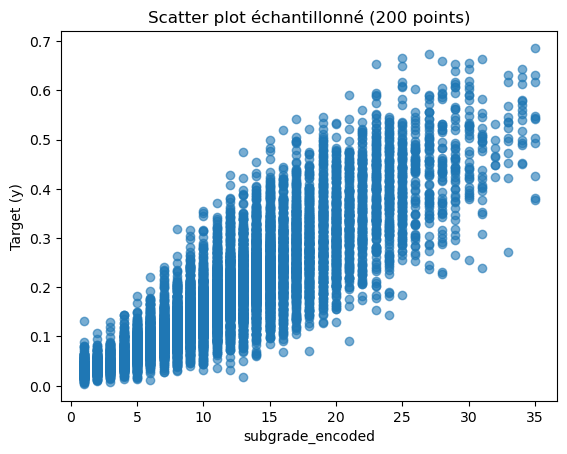

In [4]:
X_sparse = X["subgrade_encoded"]

# échantillonner 200 points sans remplacement
sample_idx = np.random.choice(len(X_sparse), size=10_000, replace=False)
X_sample = X_sparse.iloc[sample_idx]
y_sample = y.iloc[sample_idx]

plt.scatter(X_sample, y_sample, alpha=0.6)
plt.xlabel("subgrade_encoded")
plt.ylabel("Target (y)")
plt.title("Scatter plot échantillonné (200 points)")
plt.show()

In [5]:
from sklearn.compose import ColumnTransformer


lr = LinearRegression()


X_sparse = X[["subgrade_encoded", "dti",  "int_rate",
              "loan duration",
                "purpose"
                ]]


# Préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ["subgrade_encoded", "dti",
              #"grade_encoded",  
              "int_rate", "loan duration"]),
        ("cat", OneHotEncoder(), ["purpose"])
    ],
    remainder="drop"
)

from sklearn.model_selection import TimeSeriesSplit

# Modèle
lr = LinearRegression()
pipe = make_pipeline(preprocessor, lr)

cv = TimeSeriesSplit()
lr_cv = cross_validate(pipe, X_sparse, y, 
                       cv=cv,
                       return_estimator=True,
                       return_train_score=True)

In [6]:
lr_cv

{'fit_time': array([0.59008193, 1.13558841, 1.36891127, 1.66069961, 2.16013813]),
 'score_time': array([0.23917794, 0.23045063, 0.2136817 , 0.20142126, 0.19796705]),
 'estimator': [Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
                                                    ['subgrade_encoded', 'dti',
                                                     'int_rate',
                                                     'loan duration']),
                                                   ('cat', OneHotEncoder(),
                                                    ['purpose'])])),
                  ('linearregression', LinearRegression())]),
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('num', StandardScaler(),
                                                    ['subgrade_encoded', 'dti',
                                                     'int_rate',
                  

<Axes: >

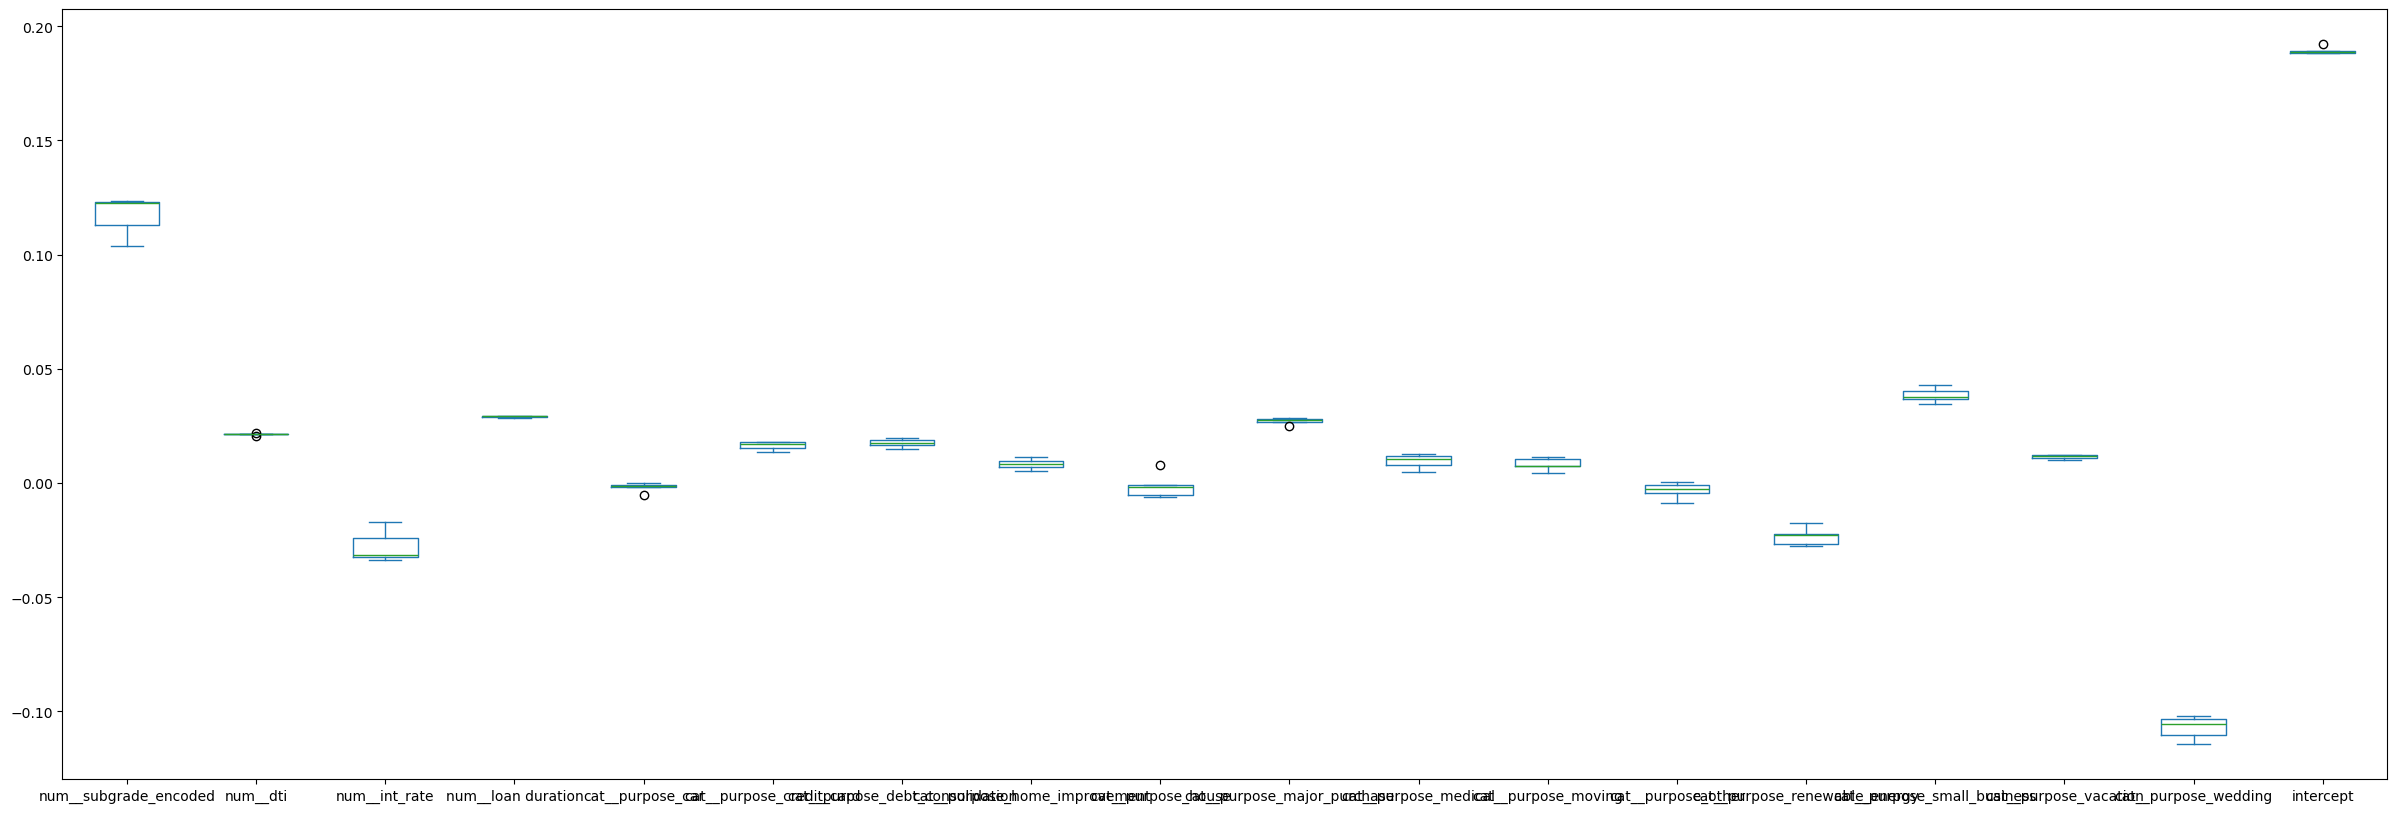

In [7]:
feature_names = lr_cv["estimator"][1][0].get_feature_names_out()


coefs = pd.DataFrame(
    [
        lr_cv["estimator"][i][-1].coef_ for i in range(len(lr_cv["estimator"]))
    ],
    columns=feature_names,
)

coefs["intercept"] = [
    lr_cv["estimator"][i][-1].intercept_ for i in range(len(lr_cv["estimator"]))
]

coefs.plot(kind="box", figsize=(30, 10), fontsize=10)

<Axes: >

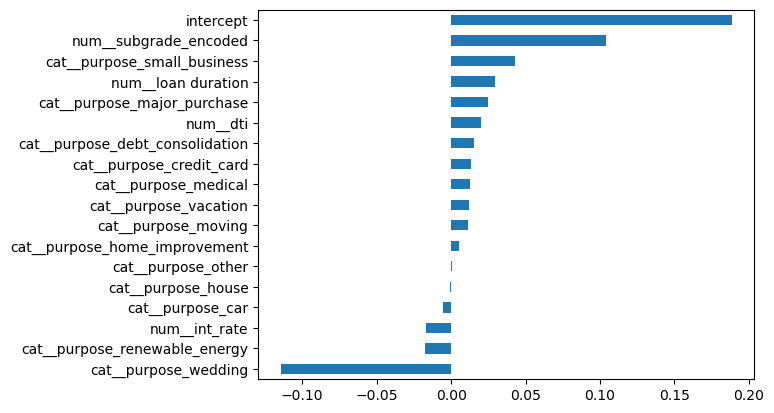

In [8]:
coefs.iloc[-1, :].sort_values().plot(kind="barh")

Houston we have a problem, c'est négatif

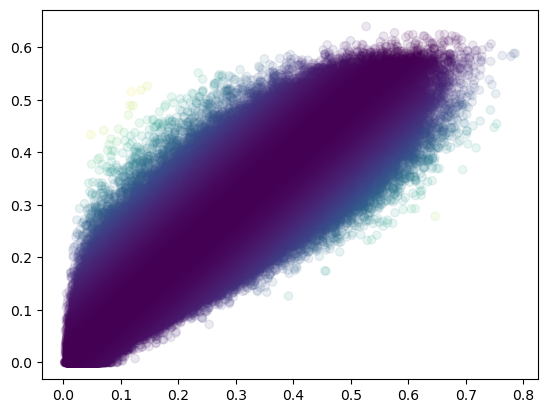

In [9]:
predictions = lr_cv["estimator"][-1].predict(X_sparse)
predictions[predictions < 0] = 0
err = (y - predictions)**2
plt.scatter(y, predictions, alpha=0.1, c=err, cmap="viridis")

In [10]:
from sklearn.metrics import r2_score
r2_score(y, predictions)

0.8238806532267186

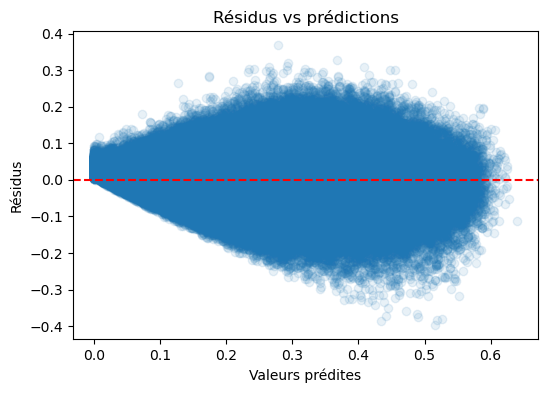

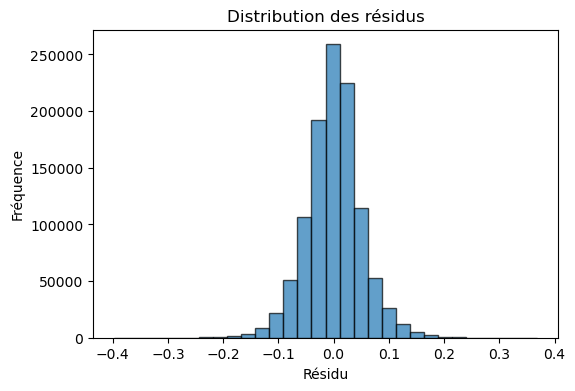

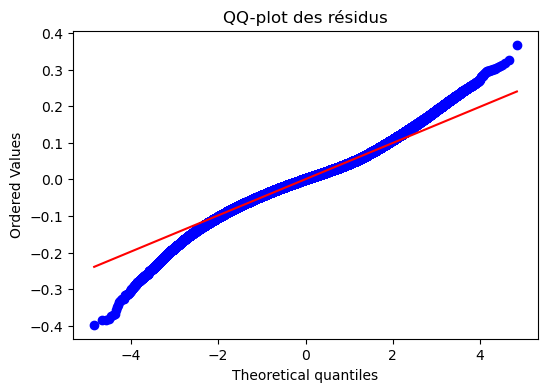

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

residuals = y - predictions

# --- 1. Scatter y_pred vs résidus ---
plt.figure(figsize=(6,4))
plt.scatter(predictions, residuals, alpha=0.1)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valeurs prédites")
plt.ylabel("Résidus")
plt.title("Résidus vs prédictions")
plt.show()

# --- 2. Histogramme des résidus ---
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, edgecolor="k", alpha=0.7)
plt.xlabel("Résidu")
plt.ylabel("Fréquence")
plt.title("Distribution des résidus")
plt.show()

# --- 3. QQ-plot ---
plt.figure(figsize=(6,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot des résidus")
plt.show()


In [12]:
from scipy.stats import shapiro

shapiro(residuals)

/home/basile/.conda/envs/base_ds/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 1086236.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.986068508919718), pvalue=np.float64(1.9647366867157936e-97))

In [13]:
coefs

,num__subgrade_encoded,num__dti,num__int_rate,num__loan duration,cat__purpose_car,cat__purpose_credit_card,cat__purpose_debt_consolidation,cat__purpose_home_improvement,cat__purpose_house,cat__purpose_major_purchase,cat__purpose_medical,cat__purpose_moving,cat__purpose_other,cat__purpose_renewable_energy,cat__purpose_small_business,cat__purpose_vacation,cat__purpose_wedding,intercept
0,0.123608,0.021432,-0.031539,0.028275,-0.000214,0.018079,0.019483,0.011360,0.007945,0.027875,0.004965,0.004459,-0.008987,-0.027702,0.034688,0.009996,-0.101948,0.188430
1,0.122623,0.021521,-0.033614,0.029261,-0.001483,0.018076,0.018689,0.009406,-0.001720,0.028262,0.007909,0.007316,-0.004185,-0.026752,0.036965,0.011032,-0.103516,0.188387
2,0.122968,0.022020,-0.032507,0.029265,-0.000884,0.016885,0.017603,0.008476,-0.006099,0.027611,0.010304,0.007618,-0.002713,-0.022770,0.037817,0.011859,-0.105707,0.192132
3,0.113043,0.021310,-0.024243,0.028725,-0.001872,0.015494,0.016761,0.007112,-0.005106,0.026698,0.011853,0.010372,-0.000809,-0.022533,0.040412,0.012065,-0.110446,0.189263
4,0.103924,0.020387,-0.017023,0.029190,-0.005172,0.013451,0.015083,0.005338,-0.000725,0.024908,0.012497,0.011245,0.000292,-0.017709,0.043068,0.012083,-0.114359,0.188553


In [15]:

# Récupération des coefficients pour un split donné (ex: le premier)
estimator = lr_cv["estimator"][0]
scaler = estimator.named_steps["columntransformer"].named_transformers_["num"]
ohe = estimator.named_steps["columntransformer"].named_transformers_["cat"]
model = estimator.named_steps["linearregression"]

# Noms des features après préprocessing
feature_names = estimator.named_steps["columntransformer"].get_feature_names_out()

# Coefficients scalés
coefs_scaled = pd.Series(model.coef_, index=feature_names)
# Variables
num_features = ["subgrade_encoded", "dti", "int_rate", "loan duration"]
cat_features = ["purpose"]
# --- Rapatrier à l’échelle d’origine ---
# Numériques : diviser par l’écart-type
num_coefs = coefs_scaled[[f"num__{f}" for f in num_features]]
num_coefs_original = num_coefs / scaler.scale_
num_coefs_original.index = num_features

# Catégorielles (OHE) : diviser par sqrt(p(1-p))
cat_names = ohe.get_feature_names_out(cat_features)
cat_coefs = coefs_scaled[cat_names]

# Fréquences des catégories (pour p)
p = X_sparse[cat_features].value_counts(normalize=True).reindex(ohe.categories_[0])
cat_coefs_original = cat_coefs / np.sqrt(p.values * (1 - p.values))
cat_coefs_original.index = cat_names

# Intercept corrigé
intercept_original = model.intercept_ - np.sum((scaler.mean_ / scaler.scale_) * model.coef_[:len(num_features)])

# Rassembler
coefs_original = pd.concat([num_coefs_original, cat_coefs_original])
coefs_original["intercept"] = intercept_original

print("\nCoefficients originaux (interprétables) :\n", coefs_original)

KeyError: "None of [Index(['purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',\n       'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase',\n       'purpose_medical', 'purpose_moving', 'purpose_other',\n       'purpose_renewable_energy', 'purpose_small_business',\n       'purpose_vacation', 'purpose_wedding'],\n      dtype='object')] are in the [index]"